# CTR Analysis Ver3
from 24/04/10

In [2]:
%reset -f
import numpy as np
# from scipy.constants import h, c, e, pi
# from scipy.linalg import inv
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
from fractions import Fraction
import traceback

In [3]:
##### ##### ##### ##### ##### ##### #####
exp  = lambda rad: np.exp(rad)
sin  = lambda rad: np.sin(rad)
cos  = lambda rad: np.cos(rad)
tan  = lambda rad: np.tan(rad)
asin = lambda rad: np.arcsin(rad)
acos = lambda rad: np.arccos(rad)
#
sqrt   = lambda vec: np.sqrt(vec)
norm   = lambda vec: np.linalg.norm(vec)
square = lambda vec: np.power(vec, 2)
##### ##### ##### ##### ##### ##### #####
def vec(*args): return np.array([*args])
def uvec(*args): 
    vec = np.array([*args])
    return  vec / np.linalg.norm(vec)
#
def prod(RES):
    INF = np.where(np.isinf(RES))
    RES[INF] = 0
    PRD = np.prod(RES, axis=1)
    if INF[0].size != 0: PRD[INF[0]] = inf
    return PRD
##### ##### ##### ##### ##### ##### #####
pi   = np.pi
inf  = np.inf
#
eps0 = 8.854187817E-12

In [4]:
def cube3d(arr, dim=0b001):
    if dim == 0b100:   return np.transpose(np.array(arr),(0, 2, 1))[:,:,::-1]
    elif dim == 0b010: return np.transpose(np.array(arr),(2, 0, 1))[::-1,:,::-1]
    elif dim == 0b001: return np.transpose(np.array(arr),(1, 2, 0))[:,:,::-1]
    else: return

def cuberange(X, Y, Z):
    for i in range(X):
        for j in range(Y):
            for k in range(Z):
                yield (i, j, k)

def span(eigenValues, eigenVector):
    return np.tensordot(eigenValues, eigenVector, axes=0)


In [5]:
def PIticks(start, end, step):
    v = np.arange(start, end+step, step)
    txt = []
    for ii in v:
        f = Fraction(ii)
        if f==0:
            txt.append(0)
            continue
        #
        if   f.numerator ==  1: num = 'π'
        elif f.numerator == -1: num = '-π'
        else: num = f'{f.numerator}π'
        #
        if f.denominator == 1: txt.append(num)
        else : txt.append(f'{num}/{f.denominator}')
    return v*pi, txt

# 
---

In [6]:
# https://lampz.tugraz.at/~hadley/ss1/crystaldiffraction/atomicformfactors/formfactors.php
AtomicFormFactor = {
	#		a1		b1		a2		b2		a3		b3		a4		b4		c		
	'Sr'  : [17.5663, 1.5564, 9.8184, 14.0988, 5.422, 0.1664, 2.6694, 132.376, 2.5064],
	'Sr2+': [18.0874, 1.4907, 8.1373, 12.6963, 2.5654, 24.5651, -34.193, -0.0138, 41.4025],
	'Ti'  : [9.7595, 7.8508, 7.3558, 0.5, 1.6991, 35.6338, 1.9021, 116.105, 1.2807],
	'Ti2+': [9.11423, 7.5243, 7.62174, 0.457585, 2.2793, 19.5361, 0.087899, 61.6558, 0.897155],
	'Ti3+': [17.7344, 0.22061, 8.73816, 7.04716, 5.25691, -0.15762, 1.92134, 15.9768, -14.652],
    'Ti4+': [19.5114, 0.178847, 8.23473, 6.67018, 2.01341, -0.29263, 1.5208, 12.9464, -13.28],
    'O'   : [3.0485, 13.2771, 2.2868, 5.7011, 1.5463, 0.3239, 0.867, 32.9089, 0.2508],
    'O1-' : [4.1916, 12.8573, 1.63969, 4.17236, 1.52673, 47.0179, -20.307, -0.01404, 21.9412],
	'Ru'  : [19.2674, 0.80852, 12.9182, 8.43467, 4.86337, 24.7997, 1.56756, 94.2928, 5.37874],
    'Ru3+': [18.5638, 0.847329, 13.2885, 8.37164, 9.32602, 0.017662, 3.00964, 22.887, -3.1892],
    'Ru4+': [18.5003, 0.844582, 13.1787, 8.12534, 4.71304, 0.36495, 2.18535, 20.8504, 1.42357],
    'Nd'  : [22.6845, 2.66248, 19.6847, 0.210628, 12.774, 15.885, 2.85137, 137.903, 1.98486],
    'Nd3+': [21.961, 2.52722, 19.9339, 0.199237, 12.12, 14.1783, 1.51031, 30.8717, 1.47588],
    'Ni'  : [12.8376, 3.8785, 7.292, 0.2565, 4.4438, 12.1763, 2.38, 66.3421, 1.0341],
    'Ni2+': [11.4166, 3.6766, 7.4005, 0.2449, 5.3442, 8.873, 0.9773, 22.1626, 0.8614],
    'Ni3+': [10.7806, 3.5477, 7.75868, 0.22314, 5.22746, 7.64468, 0.847114, 16.9673, 0.386044],
    'Ga'  : [15.2354, 3.0669, 6.7006, 0.2412, 4.3591, 10.7805, 2.9623, 61.4135, 1.7189],
    'Ga3+': [12.692, 2.81262, 6.69883, 0.22789, 6.06692, 6.36441, 1.0066, 14.4122, 1.53545]
}

---

In [7]:
class Xray():
    CuKa1 = 1.5406
    def __init__(self, wavelength = 1.5406):
        self.wavelength = wavelength # Å unit
        self.K = 2 * pi / wavelength
    def __call__(self, *args):
        return self.K
    def tthetas2dks(self, tthetas):
        return 2 * self.K * sin(tthetas/2)
# Usage
CuKa1 = Xray(Xray.CuKa1)

In [8]:
class Atom():
    def __init__(self, Z, def_name = None):
        self.Z = Z
        if def_name == None:
            (_,_,_,text)=traceback.extract_stack()[-2]
            def_name = text[:text.find('=')].strip()
        self.def_name = def_name
    def __call__(self):
        return self.def_name
    def __truediv__(self, num):
        return Atom(self.Z / num.Z, def_name=self.def_name)

# Usage
Sr = Atom(38)
Ti = Atom(22)
O  = Atom(8)
Ru = Atom(44)
Nd = Atom(60)
Ni = Atom(28)
Ga = Atom(31)

In [9]:
class Molecule():
    def __init__(self, structure, abc, def_name = None):
        self.structure = structure
        self.abc = vec(*abc)
        if def_name == None:
            (_,_,_,text)=traceback.extract_stack()[-2]
            def_name  = text[:text.find('=')].strip()
        self.def_name = def_name
    def __call__(self, *args):
        if len(args)>0:
            return {self.def_name: vec(*args)}
        return self.def_name
    #
    def perovskite(A, B, O): # Atoms
        A /= Atom(8)
        O /= Atom(2)
        return cube3d([
            [[A, 0, A], [0, O, 0], [A, 0, A]],
            [[0, O, 0], [O, B, O], [0, O, 0]],
            [[A, 0, A], [0, O, 0], [A, 0, A]]
        ], 0b100)
    def pseudocubic(*abc):
        a, b, c = abc
        ac      = np.sqrt(a**2 + b**2) / 2
        cc      = c / 2
        return np.array((ac, ac, cc))
    def const_volume_abc(self, film_abc):
        a, b, _ = self.abc
        return np.array([a, b, np.prod(film_abc) / (a*b)])
    def strain(self, film):
        return Molecule(
            structure = film.structure,
            abc = self.const_volume_abc(film.abc)
        )
    def __truediv__(self, substrate):
        return Molecule(
            structure = self.structure,
            abc = substrate.const_volume_abc(self.abc),
            def_name  = self.def_name + '/' + substrate.def_name
    )
    #
    def GG2HKL(self, GG, nref=vec(0,0,1)):
        nref = uvec(*nref)
        QQ   = span(GG, nref)
        # Q * abc = 2 * pi * hkl
        HKL = QQ * self.abc / 2 / pi
        return HKL
    # def hkls2Gs(self, hkls):
    #     return np.linalg.norm(2 * pi * hkls / self.abc , axis = 1)

# Usage
sto = Molecule(
    structure = Molecule.perovskite(Sr, Ti, O),
    abc = (3.905, 3.905, 3.905)
)
sro = Molecule(
    structure = Molecule.perovskite(Sr, Ru, O),
    abc = Molecule.pseudocubic(5.567, 5.5304, 7.8446)
)
nno = Molecule(
    structure = Molecule.perovskite(Nd, Ni, O),
    abc = Molecule.pseudocubic(5.387, 5.383, 7.610)
)
ngo = Molecule(
    structure = Molecule.perovskite(Nd, Ni, O),
    abc = Molecule.pseudocubic(5.428, 5.498, 7.708)
)
sro_sto = sro/sto # sto.strain(sro)
nno_sto = nno/sto # sto.strain(nno)
ngo_sto = ngo/sto # sto.strain(ngo)

In [10]:
class Film():
    def __init__(self, molecule, NaNbNc, configuration = []):
        self.molecule = molecule
        self.NaNbNc = NaNbNc
        self.Na, self.Nb, self.Nc = NaNbNc
        #
        self.configuration = configuration

    def __call__(self, *args):
        if len(args)>0:
            return self.molecule(*args)
        return self.molecule()

    def __truediv__(self, substrate):
        return Film(self.molecule, self.NaNbNc, [*self.configuration, substrate])
    
class Sample():
    def __init__(self, top_film):
        if top_film.configuration == []:
            self.films = [top_film]
        else:
            self.films = [top_film, *top_film.configuration]
        self.bulk = self.films.pop()
    def __call__(self):
        return vec(*[x() for x in self.films], self.bulk())

# Usage
STO = Film(sto, (10, 10, 100))
SRO = Film(sro, (10, 10, 10))
NNO = Film(nno, (10, 10, 10))
NGO = Film(ngo, (10, 10, 10))
#
SRO_sto = Film(sro/sto, (10, 10, 100))
NNO_sto = Film(nno/sto, (10, 10, 100))
##
SRO_STO = Sample(SRO_sto/STO)
NNO_SRO_STO = Sample(NNO_sto/SRO_sto/STO)

# SAMP = Sample(SRO)
print('Total Configuration )')
print(NNO_SRO_STO())
print(f'BULK )  {NNO_SRO_STO.bulk()}')
print(f'FILM )  {vec(*[x() for x in NNO_SRO_STO.films])}')

Total Configuration )
['nno/sto' 'sro/sto' 'sto']
BULK )  sto
FILM )  ['nno/sto' 'sro/sto']


---

In [11]:
class Detector:
    def __init__(self, xray, atom=[], molecule=[], film=[], sample=[]):
        if str(atom.__class__) == "<class '__main__.Atom'>": self.atom = vec(atom)
        else : self.atom = vec(*atom)
        #
        if str(molecule.__class__) == "<class '__main__.Molecule'>": self.molecule = vec(molecule)
        else: self.molecule = vec(*molecule)

        if str(film.__class__) == "<class '__main__.Film'>": self.film = vec(film)
        else: self.film = vec(*film)

        self.sample   = sample
        self.HKL = {}
        #
        self.xray     = xray
        self.TTHETA   = np.linspace(1E-10, pi, 1000)
        self.DEGREE   = np.rad2deg(self.TTHETA)
        self.DK       = xray.tthetas2dks(self.TTHETA)
        self.nref     = {}
        self.loc      = (1, 1, 1)

    def align(self, nref):
        # nref = {'sto': (0, 0, 1)}  또는  sto(0, 0, 1)
        if str(nref.__class__) == "<class 'dict'>":
            self.nref = nref
        # nref = [sto(0,0,1), nno(0,0,2)]
        elif str(nref[0].__class__) == "<class 'dict'>":
            self.nref = dict((key, value) for dictionary in nref for key, value in dictionary.items())
        else: 
            print('ERROR_')
            print("EX) align(nref=Molecule(0,0,1))")
            print("EX) align(nref=Film(0,0,1))")

    def tthetaChange(self, ttheta):
        self.TTHETA = vec(*ttheta)
        self.DEGREE   = np.rad2deg(self.TTHETA)
        self.DK     = self.xray.tthetas2dks(vec(*ttheta))
    def degreeChange(self, start, end, length):
        self.tthetaChange(np.linspace(np.deg2rad(start), np.deg2rad(end), length))

    def errorCheck(self):
        if not len(self.nref.keys()):
            print("ERROR_")
            print("You need to set the scan orientation first.")
            print("EX) Detector.align(self, nref)")
            return True
        else: return False
    
    # Atomic Form Factor
    def AFF(self, REF=True):
        res = []
        for atom in self.atom:
            if REF:
                (a1, b1, a2, b2, a3, b3, a4, b4, c) = AtomicFormFactor[atom.def_name]
                res.append(sum(c + vec(*[a * exp(-1 * b * np.power(self.DK/(4*pi), 2)) for a, b in zip(vec(a1, a2, a3, a4), vec(b1, b2, b3, b4))])))
            else:
                res.append(atom.Z / np.power(self.DK, 2))
        if self.atom.size == 1: return res[0]
        else : return vec(*res)
        
    # Structure Factor
    def SF(self, REF = True):
        if self.errorCheck(): return
        res = []
        for molecule in self.molecule:
            structure = molecule.structure 
            self.HKL[molecule()] = molecule.GG2HKL(self.DK, nref=self.nref[molecule()])
            # G = np.linalg.norm(2 * pi * hkls / molecule.abc, axis = 1)
            (Nx, Ny, Nz) = len(structure[:,0,0]),len(structure[0,:,0]),len(structure[0,0,:])
            sf = np.zeros(len(self.HKL[molecule()]))
            for (ii,jj,kk) in cuberange(Nx,Ny,Nz):
                if structure[ii,jj,kk]==0 : continue
                # rj는 sample의 abc 프레임 기준..
                rj = vec(ii,jj,kk) / vec(Nx-1, Ny-1, Nz-1)
                #
                self.atom = vec(structure[ii,jj,kk])
                sf = sf + self.AFF(REF) * exp(2j * pi * self.HKL[molecule()] @ rj)
            res.append(sf)
        if self.molecule.size == 1: return res[0]
        return vec(*res)
    
    # Scattering Factor E(R) && Slit fuNction
    def ER(self, SLIT = False):
        if self.errorCheck(): return
        N1 = vec(*self.loc)
        res = []
        for film in self.film:
            molecule = film.molecule
            self.HKL[molecule()] = molecule.GG2HKL(self.DK, nref=self.nref[molecule()])
            N2  = vec(*film.NaNbNc)
            #
            IX  = 2j * pi * self.HKL[molecule()]
            # N2 == inf check. (BULK)
            N3  = np.where(N2==inf, 0, N2)
            NUM = np.where(N2==inf, -exp(IX), exp(IX*N1)*(1-exp(IX*N3))  )
            # denominator == 0 check.
            DEN = np.where(np.abs(1-exp(IX)) > 1E-10, 1-exp(IX), 1)
            RES = np.where(np.abs(1-exp(IX)) > 1E-10, NUM/DEN, N2)
            #
            if SLIT:
                res.append(prod(RES))
            else:
                self.molecule = vec(molecule)
                SN  = prod(RES)
                SF  = self.SF(REF = True)
                # prod(RES) * np.where(np.isinf(RES), 1+1j, self.SF(REF=True))
                res.append(SN * np.where(np.isinf(SN), 1+1j, SF))
        if self.film.size == 1: 
            # lloc 말이 안돼. STO격자 N=10까지 하면, NNO격자는 N=10부터일수가 없다. HKL이 달라서.
            # nref 방향을 쌓아야하는데. 또 STO001 위에 NNO110 이런거 있으면 어떡하지??
            # 일단 보류.
            self.loc = N1 + N2 * vec(0,0,1)
            return res[0]
        return vec(*res)

	# Scattering Factor E(R)
    def SN(self):
        return self.ER(SLIT = True)


---

# Examples

Imaginary Part : ( 0.0 , 0.0 )


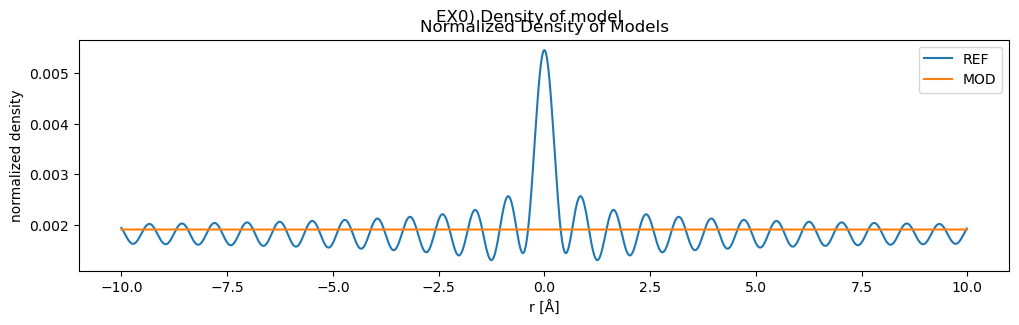

In [12]:
# AFF to n(r)
def EX0_Density():
    plt.figure(figsize = (12,3))
    # plt.subplot(1,2,1)
    R   = np.arange(-10, 10, 0.01) # Å unit
    XRD = Detector(CuKa1, atom = O)
    nG_ref  = XRD.AFF(REF=True)
    nG_mod  = XRD.AFF(REF=False)
    GG  = XRD.DK
    nR_ref = []
    nR_mod = []
    for r in R:
        nR_ref.append( np.sum(nG_ref) + np.sum(nG_ref * exp(-1j * GG * r))+np.sum(nG_ref * exp(1j * GG * r)) )
        nR_mod.append( np.sum(nG_mod) + np.sum(nG_mod * exp(-1j * GG * r))+np.sum(nG_mod * exp(1j * GG * r)) )
    print('Imaginary Part : (', norm(np.imag(nR_ref)), ',', norm(np.imag(nR_mod)), ')')
    (nR_ref, nR_mod) = map(np.real, [nR_ref, nR_mod])
    plt.plot(R, nR_ref/np.mean(nR_ref) * O.Z/(4/3 * pi * np.max(np.abs(R))**3), label = 'REF')
    plt.plot(R, nR_mod/np.mean(nR_mod) * O.Z/(4/3 * pi * np.max(np.abs(R))**3), label = 'MOD')
    # plt.plot(R, np.zeros_like(R), linestyle='dashed', linewidth=1)
    plt.legend()
    plt.title('Normalized Density of Models')
    plt.xlabel('r [Å]')
    plt.ylabel('normalized density')
    plt.suptitle('EX0) Density of model')
EX0_Density()

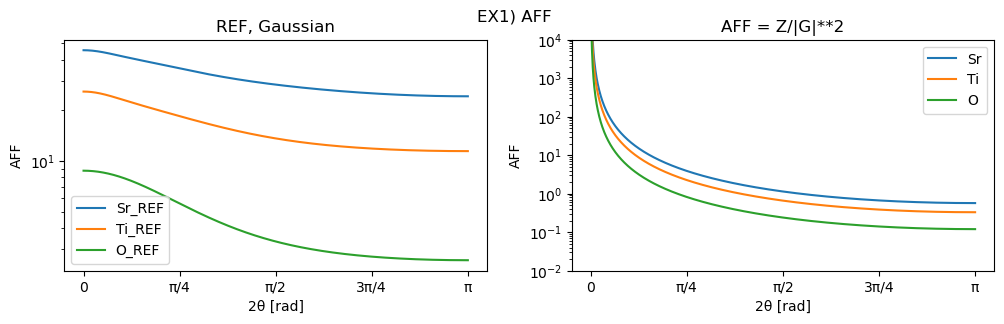

In [13]:
plt.figure(figsize=(12,3))
def EX1_AFF():
    XRD = Detector(CuKa1, atom = [Sr, Ti, O])
    AFF = XRD.AFF(REF=True)
    plt.subplot(1,2,1)
    plt.semilogy(XRD.TTHETA, AFF[0], label='Sr_REF')
    plt.semilogy(XRD.TTHETA, AFF[1], label='Ti_REF')
    plt.semilogy(XRD.TTHETA, AFF[2], label='O_REF')
    plt.xticks(*PIticks(0, 1, 1/4))
    plt.legend()
    plt.xlabel('2θ [rad]')
    plt.ylabel('AFF')
    plt.title('REF, Gaussian')
    # plt.title(f'EX1) AFF')
    plt.subplot(1,2,2)
    AFF = XRD.AFF(REF=False)
    plt.semilogy(XRD.TTHETA, AFF[0], label='Sr')
    plt.semilogy(XRD.TTHETA, AFF[1], label='Ti')
    plt.semilogy(XRD.TTHETA, AFF[2], label='O')
    plt.xticks(*PIticks(0, 1, 1/4))
    plt.legend()
    plt.xlabel('2θ [rad]')
    plt.ylabel('AFF')
    plt.ylim([1E-2, 1E4])
    plt.title('AFF = Z/|G|**2')
    plt.suptitle(f'EX1) AFF')
EX1_AFF()

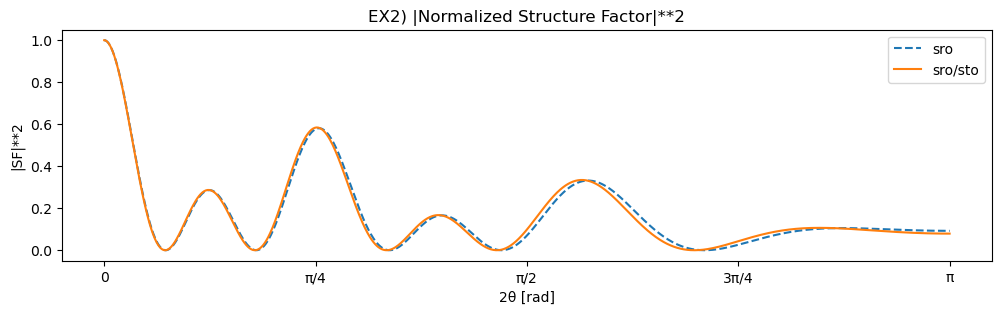

In [14]:
def EX2_SF(REF=True):
    plt.figure(figsize=(12, 3))
    XRD = Detector(CuKa1, molecule=[sro, sro_sto])
    XRD.align(nref = [sro(0,0,1), sro_sto(0,0,1)])
    SF  = XRD.SF()
    plt.plot(XRD.TTHETA, np.abs(SF[0])**2/np.max(np.abs(SF[0])**2), label='sro', linestyle='dashed')
    plt.plot(XRD.TTHETA, np.abs(SF[1])**2/np.max(np.abs(SF[1])**2), label='sro/sto')
    plt.legend()
    plt.xticks(*PIticks(0, 1, 1/4))
    plt.xlabel('2θ [rad]')
    plt.ylabel('|SF|**2')
    plt.title(f'EX2) |Normalized Structure Factor|**2')
EX2_SF()

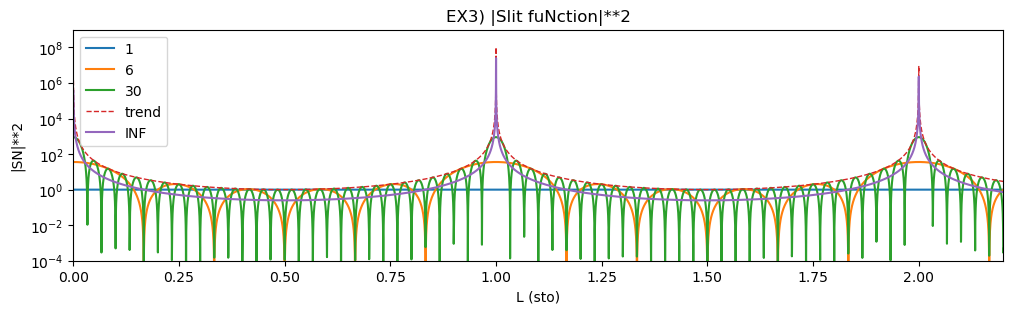

In [15]:
def EX3_SN():
    plt.figure(figsize=(12,3))    
    STO_GEN = lambda N: Film(sto, (1, 1, N))
    XRD = Detector(CuKa1, film=[STO_GEN(1), STO_GEN(6), STO_GEN(30), STO_GEN(inf)])
    XRD.align(STO(0,0,1))
    XRD.tthetaChange(np.linspace(0, pi/3, 10**4))
    SN  = XRD.SN()
    plt.semilogy(XRD.HKL[STO()][:,2], np.abs(SN[0])**2, label='1')
    plt.semilogy(XRD.HKL[STO()][:,2], np.abs(SN[1])**2, label='6')
    plt.semilogy(XRD.HKL[STO()][:,2], np.abs(SN[2])**2, label='30')
    plt.semilogy(XRD.HKL[STO()][:,2], 4*np.abs(SN[3])**2, label='trend', linewidth=1, linestyle='dashed')
    plt.semilogy(XRD.HKL[STO()][:,2], np.abs(SN[3])**2, label='INF')
    plt.legend()
    plt.xlabel('L (sto)')
    plt.ylabel('|SN|**2')
    plt.title(f'EX3) |Slit fuNction|**2')
    plt.xlim([0, 2.2])
    plt.ylim([0.0001, 1E9])
    #
    HKL = XRD.HKL[STO()]
    IX  = 2j * pi * HKL
EX3_SN()

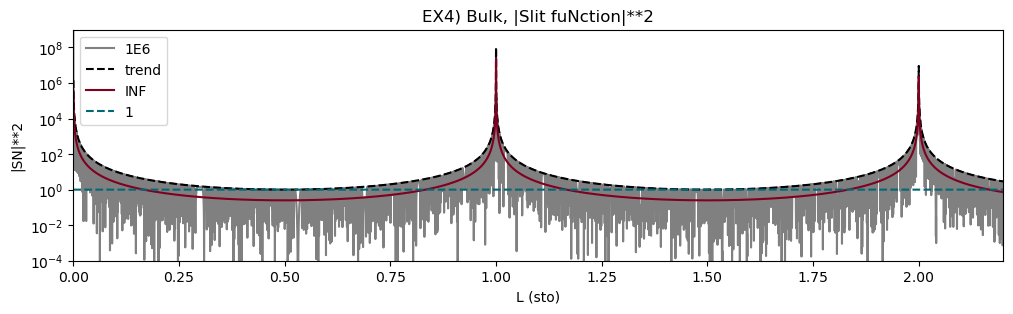

In [16]:
def EX4_BULK():
    plt.figure(figsize=(12,3))    
    STO_GEN = lambda N: Film(sto, (1, 1, N))
    XRD = Detector(CuKa1, film=[STO_GEN(1), STO_GEN(1E6), STO_GEN(inf)])
    XRD.align(STO(0,0,1))
    XRD.tthetaChange(np.linspace(0, pi/3, 10**4))
    SN  = XRD.SN()
    plt.semilogy(XRD.HKL[STO()][:,2], np.abs(SN[1])**2, label='1E6', color='grey')
    plt.semilogy(XRD.HKL[STO()][:,2], 4*np.abs(SN[2])**2, label='trend', linestyle='dashed', color='black')
    plt.semilogy(XRD.HKL[STO()][:,2], np.abs(SN[2])**2, label='INF', color='#800020')
    plt.semilogy(XRD.HKL[STO()][:,2], np.abs(SN[0])**2, label='1', color='#026873', linestyle='dashed')
    # plt.xlim([0,2.2])
    plt.legend()
    plt.xlabel('L (sto)')
    plt.ylabel('|SN|**2')
    plt.title(f'EX4) Bulk, |Slit fuNction|**2')
    plt.xlim([0, 2.2])
    plt.ylim([0.0001, 1E9])
EX4_BULK()

max :  1.0000000000000004
min :  0.9999999999999994


/Users/seongsihun/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


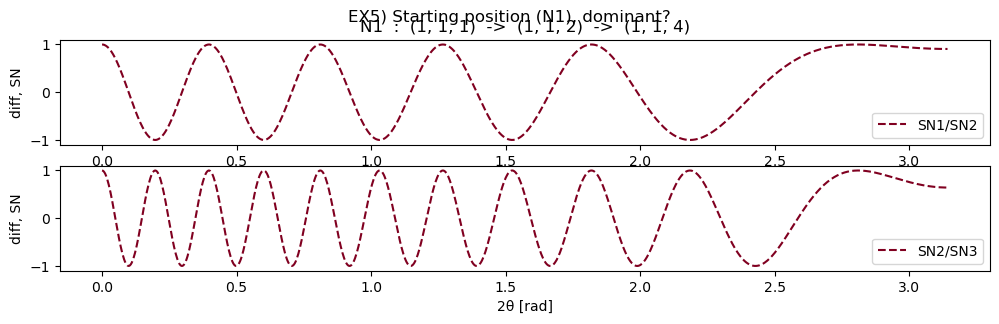

In [17]:
def EX5_START_LOC():
    plt.figure(figsize=(12, 3))
    XRD = Detector(CuKa1, film=Film(sto, (1,1,1)))
    XRD.align(STO(0,0,1))
    N01 = XRD.loc
    SN1 = XRD.SN()
    N02 = XRD.loc
    SN2 = XRD.SN()
    XRD.SN()
    N03 = XRD.loc
    SN3 = XRD.SN()
    plt.subplot(2,1,1)
    plt.plot(XRD.TTHETA, SN1/SN2, linestyle='dashed', label='SN1/SN2', color='#800020')
    plt.ylabel("diff, SN")
    # plt.ylim([0.999, 1.001])
    plt.title(f'N1  :  {tuple(N01)}  ->  {tuple(N02)}  ->  {tuple(N03)}')
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(XRD.TTHETA, SN2/SN3, linestyle='dashed', label='SN2/SN3', color='#800020')
    plt.suptitle('EX5) Starting position (N1), dominant?')
    plt.xlabel("2θ [rad]")
    plt.ylabel("diff, SN")
    # plt.ylim([0.999, 1.001])
    plt.legend()
    print('max : ', np.max(np.abs(SN1/SN2)))
    print('min : ', np.min(np.abs(SN1/SN2)))
EX5_START_LOC()

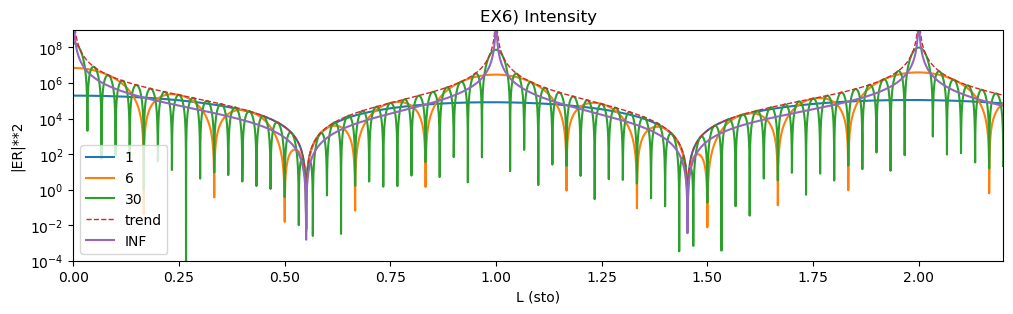

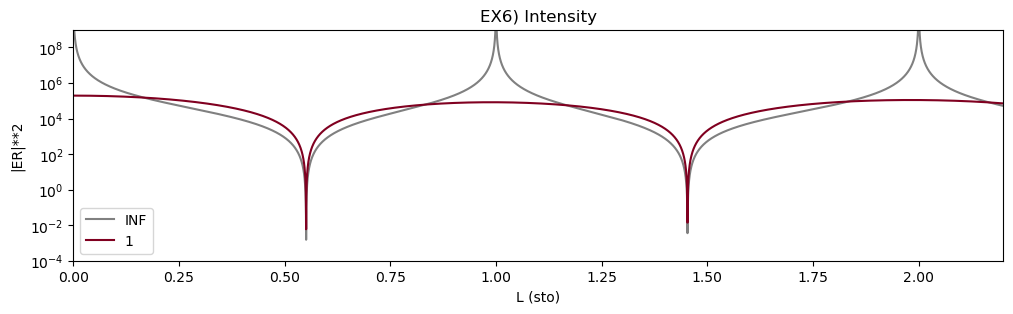

In [18]:
def EX6_FILM():
    plt.figure(figsize=(12,3))    
    STO_GEN = lambda N: Film(sto, (1, 1, N))
    XRD = Detector(CuKa1, film=[STO_GEN(1), STO_GEN(6), STO_GEN(30), STO_GEN(inf)])
    XRD.align(STO(0,0,1))
    XRD.tthetaChange(np.linspace(0, pi/3, 10**4))
    ER  = XRD.ER()
    plt.semilogy(XRD.HKL[STO()][:,2], np.abs(ER[0])**2, label='1')
    plt.semilogy(XRD.HKL[STO()][:,2], np.abs(ER[1])**2, label='6')
    plt.semilogy(XRD.HKL[STO()][:,2], np.abs(ER[2])**2, label='30')
    plt.semilogy(XRD.HKL[STO()][:,2], 4*np.abs(ER[3])**2, label='trend', linewidth=1, linestyle='dashed')
    plt.semilogy(XRD.HKL[STO()][:,2], np.abs(ER[3])**2, label='INF')
    plt.legend()
    plt.xlabel('L (sto)')
    plt.ylabel('|ER|**2')
    plt.title(f'EX6) Intensity')
    plt.xlim([0, 2.2])
    plt.ylim([0.0001, 1E9])
EX6_FILM()
def EX6_FILM_HIGHLIGHT():
    plt.figure(figsize=(12,3))    
    STO_GEN = lambda N: Film(sto, (1, 1, N))
    XRD = Detector(CuKa1, film=[STO_GEN(inf), STO_GEN(1)])
    XRD.align(STO(0,0,1))
    XRD.tthetaChange(np.linspace(0, pi/3, 10**4))
    ER  = XRD.ER()
    plt.semilogy(XRD.HKL[STO()][:,2], np.abs(ER[0])**2, label='INF', color='grey')
    plt.semilogy(XRD.HKL[STO()][:,2], np.abs(ER[1])**2, label='1'  , color='#800020')
    plt.legend()
    plt.xlabel('L (sto)')
    plt.ylabel('|ER|**2')
    plt.title(f'EX6) Intensity')
    plt.xlim([0, 2.2])
    plt.ylim([0.0001, 1E9])
EX6_FILM_HIGHLIGHT()

max :  1.0000000000000007
min :  0.9999999999999993


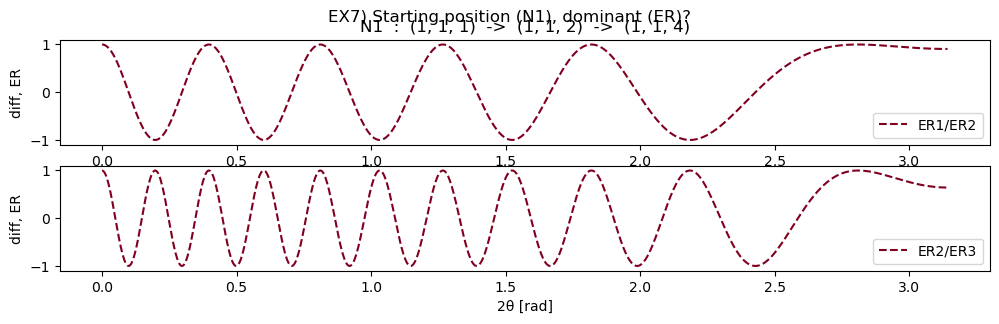

In [19]:
def EX7_START_LOC2():
    plt.figure(figsize=(12, 3))
    XRD = Detector(CuKa1, film=Film(sto, (1,1,1)))
    XRD.align(STO(0,0,1))
    N01 = XRD.loc
    ER1 = XRD.ER()
    N02 = XRD.loc
    ER2 = XRD.ER()
    XRD.ER()
    N03 = XRD.loc
    ER3 = XRD.ER()
    plt.subplot(2,1,1)
    plt.plot(XRD.TTHETA, ER1/ER2, linestyle='dashed', label='ER1/ER2', color='#800020')
    plt.ylabel("diff, ER")
    # plt.ylim([0.999, 1.001])
    plt.title(f'N1  :  {tuple(N01)}  ->  {tuple(N02)}  ->  {tuple(N03)}')
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(XRD.TTHETA, ER2/ER3, linestyle='dashed', label='ER2/ER3', color='#800020')
    plt.suptitle('EX7) Starting position (N1), dominant (ER)?')
    plt.xlabel("2θ [rad]")
    plt.ylabel("diff, ER")
    # plt.ylim([0.999, 1.001])
    plt.legend()
    print('max : ', np.max(np.abs(ER1/ER2)))
    print('min : ', np.min(np.abs(ER1/ER2)))
EX7_START_LOC2()

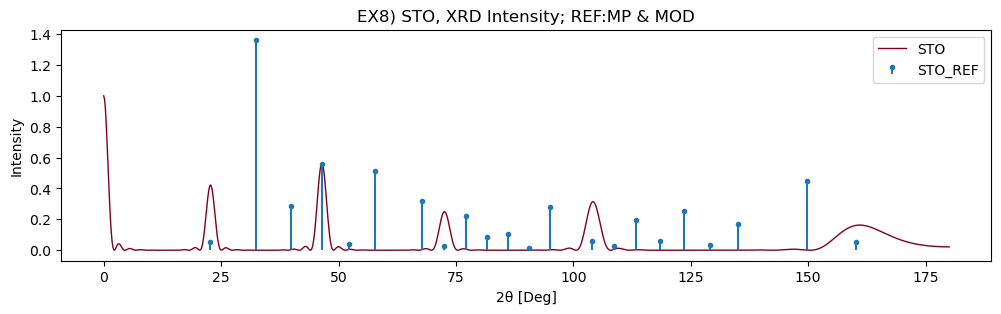

In [20]:
plt.figure(figsize=(12,3))
def EX8_STO():
    XRD = Detector(CuKa1, film = Film(sto, (10, 10, 10)))
    # XRD.degreeChange(5, 40, 1000)
    XRD.align(sto(0,0,1))
    ER = XRD.ER()
    plt.plot(XRD.DEGREE, np.abs(ER)**2/np.max(np.abs(ER)**2), color='#800020', linewidth=1, label='STO')
    # plt.semilogy(XRD.DEGREE, np.abs(ER)**2)
    X = np.rad2deg(asin(vec(1,2,3,4, 5)* CuKa1.wavelength / (2 * sto.abc[0]))) * 2
    # plt.plot(X, 0.58*vec(1,1,1,1,1), marker = '*', linewidth=0, color='red', label='PEAK')
EX8_STO()

def EX8_STO_REF():
    refTT = [
		22.727, 32.358, 39.908, 46.415, 52.281, 57.714,
		67.734, 72.469, 77.080, 81.608, 86.084, 90.534,
		94.990, 104.020, 108.657, 113.425, 118.372,
		123.562, 129.082, 135.082, 149.701, 160.228
	]
    refII = vec(*[
		3.873, 100, 21.139, 41.050, 2.922, 37.552,
		23.389, 1.868, 16.178, 6.325, 7.758, 1.036,
		20.784, 4.344, 1.918, 14.290, 4.367, 18.671,
		2.388, 12.534, 32.811, 3.766
	])
    # . , o v ^ < > 1 2 3 4 s p * h H + x D d _
    plt.stem(refTT, refII/100*1.36, label='STO_REF', markerfmt='.', basefmt=' ')
    # plt.ylim([0, 0.6])
    plt.xlabel('2θ [Deg]')
    plt.ylabel('Intensity')
    plt.title('EX8) STO, XRD Intensity; REF:MP & MOD')
    plt.legend()
EX8_STO_REF()

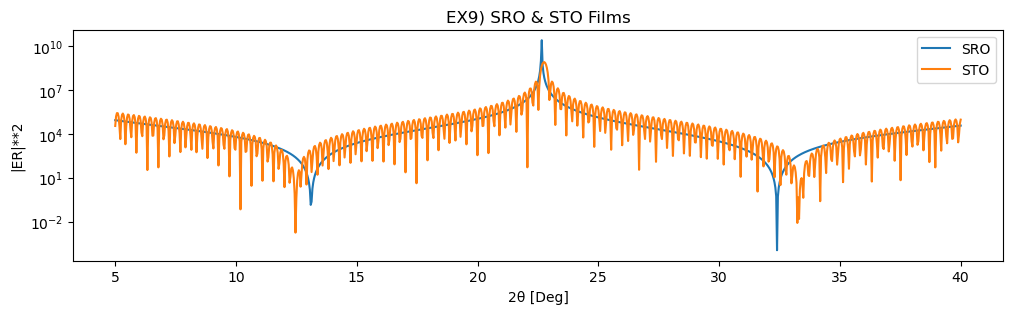

In [21]:
def EX9_SRO_sto():
    plt.figure(figsize=(12,3))
    N = 100
    XRD = Detector(CuKa1, film=[Film(sro, (1, 1, inf)), Film(sto, (1, 1, N))])
    XRD.align([sro(0,0,1), sto(0,0,1)])
    XRD.degreeChange(5, 40, 1000)
    ER  = XRD.ER()
    plt.semilogy(XRD.DEGREE, np.abs(ER[0])**2, label='SRO')
    plt.semilogy(XRD.DEGREE, np.abs(ER[1])**2, label='STO')
    plt.legend()
    plt.xlabel('2θ [Deg]')
    plt.ylabel('|ER|**2')
    plt.title(f'EX9) SRO & STO Films')
EX9_SRO_sto()

In [22]:
RAWDATA001 = '''
14.973
9.955
14.91
9.904
5.017
14.862
9.997
19.962
25.104
19.934
9.939
20.004
0
15.014
15.011
14.914
4.997
0
14.905
10.023
19.895
9.865
10.025
9.987
24.864
24.874
14.894
10.044
5.043
29.931
4.974
19.996
4.972
4.981
14.83
14.946
9.887
10.023
14.982
0
14.938
9.935
24.89
30.046
14.996
19.819
24.942
25.068
9.935
24.957
19.966
0
14.787
15.035
4.96
24.711
19.92
14.907
9.998
10.026
10.024
14.968
9.968
9.998
34.66
24.909
9.952
10.059
19.959
9.954
24.913
14.934
24.885
35.029
9.907
4.99
9.909
4.957
34.818
34.789
9.937
24.964
19.956
4.948
14.995
4.98
4.994
14.927
9.971
20.07
4.96
9.94
44.768
9.898
9.971
14.826
19.88
24.846
29.84
9.956
19.929
14.956
14.967
29.857
19.923
9.99
19.856
9.982
44.864
29.813
4.953
30.061
9.964
9.866
14.897
19.842
14.983
24.931
19.948
14.945
34.82
9.995
4.871
19.87
14.934
14.876
14.916
19.978
19.909
0
9.933
9.976
15.116
15.013
9.961
9.981
9.972
14.902
9.927
0
14.962
9.972
14.975
14.827
4.995
14.999
9.951
39.76
24.874
14.781
4.992
24.9
9.943
9.969
10.003
10.052
9.763
9.924
14.997
0
0
14.944
4.968
9.93
9.95
9.971
9.969
29.719
14.848
9.962
25.028
24.888
24.906
19.88
19.887
29.775
9.993
14.904
20.009
19.947
9.891
24.915
14.917
24.929
9.938
4.977
24.927
15.009
5.108
15.005
4.99
9.98
9.99
14.785
29.722
29.851
4.952
9.947
29.839
44.865
34.853
9.952
15.039
9.823
4.984
5.001
24.903
4.956
10.006
19.821
10.026
19.919
24.901
4.98
0
24.941
14.925
5.008
20.01
4.972
9.913
19.828
4.962
9.943
19.937
10.035
14.949
24.856
9.897
4.943
9.946
4.972
10.003
19.847
9.994
9.922
9.897
9.912
4.999
9.916
9.961
29.817
29.904
4.99
14.91
4.952
0
29.764
14.994
14.932
24.897
4.971
9.952
19.946
19.868
4.921
24.907
9.914
34.88
20.002
30.056
34.82
0
0
5.024
29.967
4.976
9.951
14.961
5.017
10.08
19.959
24.918
29.757
5.031
14.968
19.83
19.934
4.95
19.934
24.814
29.934
19.908
15.017
19.753
4.969
14.98
4.973
24.978
9.983
9.975
19.864
34.783
19.985
24.908
24.988
25.001
9.983
0
9.857
19.916
0
4.974
15.003
14.913
4.949
10.004
4.981
14.978
24.906
0
9.936
4.935
24.772
9.897
15.091
19.916
5.02
14.912
14.963
19.978
0
9.912
19.852
4.99
9.855
10.002
10.002
4.999
39.731
19.968
4.994
19.962
9.935
9.97
14.968
10.064
19.889
14.973
4.943
14.901
9.944
14.988
9.994
19.928
15.017
49.886
5.001
4.964
9.981
10.078
19.843
14.985
14.932
24.831
20.015
19.872
19.811
4.996
19.859
9.944
14.877
19.918
29.929
15.029
19.984
19.844
9.976
20.037
4.996
24.987
25.015
10.015
4.974
9.997
19.953
24.899
19.971
14.906
25.024
0
34.905
14.89
24.944
19.896
4.971
14.881
24.85
30.013
14.912
9.998
9.845
14.994
29.994
9.899
9.979
5.051
20.022
19.925
9.94
14.886
10.054
19.838
19.919
14.853
19.92
15.069
10.06
0
19.894
34.777
24.972
24.999
9.919
24.89
24.814
14.894
10.01
19.918
10.012
0
29.866
4.97
4.986
14.96
19.933
5.058
9.89
19.886
9.956
4.979
9.945
20.053
4.978
9.936
10.024
9.92
0
29.876
9.996
9.892
24.995
14.839
9.939
49.791
19.873
14.974
15.014
24.756
29.989
9.977
14.954
19.918
14.985
24.965
19.805
24.919
15.019
9.931
25.017
9.847
19.899
9.993
4.967
5.001
29.769
34.829
4.957
9.992
4.941
25.126
24.827
44.814
19.887
4.961
10.036
29.844
19.916
14.989
10.027
9.983
19.938
5.036
4.978
19.927
44.948
24.973
5.003
4.963
14.931
9.944
19.997
19.95
14.963
10.039
4.982
14.973
9.966
19.998
19.857
19.987
34.981
0
10.001
19.928
34.842
9.93
10.015
14.893
20.019
19.66
24.962
0
9.936
14.865
9.953
29.786
14.949
0
14.995
34.869
19.91
29.732
19.967
0
9.931
19.898
25.033
14.953
0
10.06
5.038
14.906
14.913
9.971
9.947
4.99
24.866
14.89
19.928
10.01
14.907
9.993
4.985
9.887
19.949
14.922
9.947
4.978
29.912
9.991
24.897
14.873
4.985
15.038
15.006
5.004
44.962
5.024
19.835
44.85
24.954
19.93
9.952
14.911
14.956
10.011
15.031
19.969
34.896
4.961
19.856
9.833
29.854
24.911
25.072
14.921
29.87
5.042
24.847
24.843
25.041
14.969
0
9.972
25.029
14.932
9.909
14.9
4.953
14.927
9.948
10.03
4.961
19.846
19.967
14.929
19.766
19.918
20.142
29.997
25.032
19.986
14.955
19.944
19.951
39.947
14.895
10
34.888
14.9
19.927
24.854
29.939
9.958
14.877
14.965
14.939
9.95
14.963
9.986
24.942
14.938
4.985
29.881
19.96
29.973
34.724
14.922
24.76
19.971
14.968
0
24.954
25.02
14.866
19.806
4.903
29.851
20
24.918
4.992
19.881
29.898
4.871
39.861
30.026
14.997
29.982
29.866
35.021
20.014
14.957
19.857
24.999
24.957
39.781
0
34.915
24.809
19.89
29.977
10.086
24.972
20.001
9.991
25.054
19.903
50.007
9.968
14.882
39.844
9.967
29.878
29.926
9.968
34.929
24.927
30.009
14.949
9.973
25.1
39.911
9.982
20.024
19.887
9.947
10.045
9.992
24.863
9.952
4.922
5.008
9.936
14.884
29.87
24.846
29.919
44.893
15.002
24.943
14.928
9.945
24.991
25.128
24.875
14.883
10.017
9.973
10.017
19.907
20.079
14.961
34.851
14.962
49.955
34.841
24.896
29.847
39.833
14.95
24.892
10.007
24.888
9.977
40.028
4.907
24.881
39.734
29.939
19.897
39.818
14.987
24.866
24.846
24.987
19.875
19.979
9.967
19.917
4.98
9.904
64.688
14.958
34.845
9.92
24.923
29.994
24.931
54.899
29.823
29.93
19.969
15.071
59.78
29.848
44.804
5.003
19.953
24.879
14.963
19.795
14.942
0
54.753
24.819
44.805
24.828
44.901
34.954
34.922
44.845
19.894
19.823
54.849
14.931
39.9
44.923
24.945
49.933
34.771
49.988
24.892
49.725
5.031
24.904
49.972
44.797
50.079
19.971
44.75
54.811
55.062
19.983
54.773
39.892
24.877
65.105
69.962
44.878
34.963
44.894
19.908
44.955
54.774
9.97
29.88
44.799
49.901
64.788
54.76
49.742
39.71
44.814
54.808
34.92
44.799
54.815
54.829
29.902
24.901
49.712
59.929
44.819
39.676
44.858
64.793
29.875
24.995
44.695
59.767
64.71
59.805
49.792
59.658
44.565
70.04
89.529
39.901
59.935
89.593
59.618
29.881
65.074
79.549
64.636
94.917
89.593
74.572
79.741
109.569
74.902
79.83
104.554
74.67
139.509
114.989
79.625
94.538
89.562
84.77
104.458
99.373
104.552
129.57
124.902
49.736
94.603
124.446
119.674
114.546
134.636
94.653
189.39
129.521
89.349
159.051
169.771
124.706
114.432
134.35
104.678
144.729
189.3
109.943
209.511
204.266
199.365
214.481
189.607
169.253
244.282
139.874
244.092
249.287
194.719
279.352
244.143
264.402
264.321
299.213
294.04
268.554
324.068
324.27
443.566
373.893
383.753
379.067
363.906
323.998
434.729
493.291
464.179
588.122
607.749
627.646
757.175
637.8
627.733
777.512
857.534
937.386
1031.865
1022.103
1071.553
1414.164
1405.538
1714.668
1928.746
1878.367
2203.268
2188.758
2781.267
3168.972
3792.086
4629.314
5536.523
6681.757
9029.656
12388.792
16823.886
24853.33
40941.984
89527.958
383653.119
1509000.603
5051026.487
5561411.167
3177149.64
1796362.005
1167640.53
643793.428
516730.07
206378.649
30526.179
15138.738
10155.433
7706.891
6093.024
5200.91
4206.09
3667.162
2893.583
2620.458
2417.528
2147.419
1693.591
1658.625
1504.934
1380.537
1195.546
1136.776
996.616
932.181
847.021
856.765
781.708
593.784
687.969
693.152
553.045
448.381
519.162
518.08
523.289
403.98
433.608
393.786
343.895
324.071
368.513
348.966
338.973
269.393
288.379
279.267
288.744
254.068
268.901
288.952
239.16
259.182
209.438
209.522
194.405
169.824
189.525
244.395
124.461
179.276
84.527
169.468
159.448
174.691
179.324
159.725
129.349
109.395
94.528
164.513
144.731
124.652
104.591
144.244
69.726
99.576
115.107
99.39
139.566
79.549
84.886
124.739
99.623
69.782
129.271
84.638
54.874
104.75
69.942
84.686
69.743
84.451
94.705
54.534
79.762
49.793
94.919
84.511
64.649
59.66
79.546
44.835
109.894
54.861
59.814
54.722
54.779
59.877
39.958
49.631
44.673
29.778
44.76
84.526
59.682
39.917
34.863
99.859
39.764
49.741
35.003
29.8
54.736
49.955
34.924
59.941
59.892
34.837
59.819
39.89
84.616
49.784
59.88
44.922
44.86
84.798
34.902
69.641
34.9
24.857
49.772
29.973
14.947
39.911
54.85
39.814
29.991
29.799
40.029
39.899
'''

In [23]:
RAWDATA111 = '''
4.994
9.945
15.003
4.944
4.984
5
24.872
9.931
14.938
34.863
15.024
15.007
9.871
19.928
34.864
19.997
24.882
14.915
9.94
19.897
5.028
4.986
19.916
34.959
39.751
15.065
39.98
24.879
24.91
15.016
19.89
15.035
14.907
14.904
29.948
0
15.005
14.889
19.74
25.018
4.984
19.948
24.909
15.028
4.956
24.871
15.129
24.943
19.88
20.014
24.969
19.792
19.94
4.956
24.855
19.875
24.908
24.907
39.945
39.836
9.953
24.92
39.869
14.954
0
19.888
9.997
4.971
24.789
9.831
29.817
44.878
5.003
14.959
0
25.063
19.967
34.923
20.125
20.059
24.907
19.932
14.948
9.913
14.951
14.931
14.953
4.977
20.053
19.939
4.936
34.828
19.954
14.891
19.902
29.984
24.847
14.958
19.831
24.855
9.917
10.042
5.023
29.809
0
24.982
24.928
54.624
34.978
24.924
20.054
9.949
24.982
24.958
29.943
14.913
35.027
29.916
5.007
4.94
14.993
44.504
24.851
24.862
25.009
9.9
20.099
19.783
29.914
34.843
44.79
34.948
34.918
15.017
24.894
29.89
19.982
4.852
39.8
34.946
24.864
14.86
29.926
5.027
19.938
39.768
4.983
19.884
29.906
24.927
9.99
44.745
39.88
19.849
9.937
14.953
29.919
19.902
19.925
19.869
29.885
24.976
24.923
19.944
34.975
35.012
34.809
9.993
39.835
34.766
24.957
19.932
49.908
24.884
35.111
19.902
4.978
30.008
44.82
64.797
30.012
39.858
44.867
29.866
39.978
34.811
29.89
34.868
59.739
59.799
44.988
14.952
44.785
24.848
39.763
44.761
44.755
59.724
64.982
44.941
39.746
14.978
24.83
15.007
69.891
49.849
59.796
44.81
40.029
59.883
69.631
59.943
34.918
19.894
54.887
39.969
35.006
49.782
59.822
59.743
44.819
49.6
64.741
79.669
79.76
64.793
54.961
79.408
79.651
99.587
89.693
69.749
54.889
104.676
54.828
104.806
90.076
75.124
109.875
59.858
69.806
94.769
89.753
124.69
114.789
74.601
159.536
109.827
59.854
159.491
134.535
144.713
139.596
134.994
119.542
194.473
164.451
238.796
149.465
184.066
189.223
233.773
308.901
199.294
214.047
318.863
254.207
343.762
269.05
308.872
388.901
458.669
408.981
403.18
498.127
502.86
672.404
652.535
761.893
717.711
861.847
965.574
1111.66
1386.979
1489.91
2042.977
2298.056
2733.236
3987.347
5501.68
8275.551
13423.281
25664.389
131911.746
449723.001
1391514.198
3419172.137
3299292.451
1686380.444
854164.284
209754.352
25750.432
11677.286
7495.298
5201.565
3980.734
2731.564
2197.237
1904.059
1669.685
1335.721
1244.783
1156.471
997.208
926.701
751.81
573.46
603.545
602.802
552.92
433.304
438.798
378.747
308.311
324.303
264.509
259.008
223.902
284.14
269.054
239.014
233.875
194.296
179.292
194.788
129.548
174.386
149.588
139.482
114.717
104.791
104.58
119.337
99.511
134.303
94.659
124.674
94.659
74.553
44.985
69.669
84.98
54.835
79.8
69.565
84.737
69.757
84.723
84.523
64.752
69.57
34.942
89.731
25.008
54.648
29.774
99.856
74.851
39.93
54.989
64.892
89.798
44.795
59.862
44.925
49.684
24.941
49.949
49.953
54.98
59.687
9.976
45.044
29.933
59.825
29.855
69.986
44.801
44.928
40.037
30.014
30.002
19.934
29.992
24.988
29.956
24.836
49.696
65.014
14.957
24.983
24.818
34.971
24.83
20.055
19.857
59.85
29.897
24.985
24.872
24.932
24.919
44.992
20.007
29.835
29.818
34.871
49.928
24.948
29.82
25.075
59.695
24.921
24.998
14.871
14.913
34.816
24.922
19.959
19.987
29.96
25.005
29.988
29.784
4.984
39.898
29.905
19.928
49.641
24.957
54.846
29.959
19.869
19.93
39.722
19.767
34.809
19.965
25.058
25.061
14.927
19.989
20.067
19.902
14.888
0
24.967
4.984
9.974
19.993
10.033
19.899
14.887
34.907
34.777
0
14.939
24.797
4.968
14.963
14.84
19.978
24.883
4.976
29.805
24.965
29.919
20.006
34.952
14.976
24.99
9.988
19.892
14.987
4.942
29.903
29.927
9.981
15.024
9.999
14.94
4.989
9.944
19.945
24.913
19.912
5.036
20.015
15.015
39.862
9.912
9.944
20.022
10.026
10.005
34.859
5
19.954
24.916
24.86
4.993
14.955
15.061
15.031
14.935
4.969
14.834
24.905
24.966
4.961
4.974
44.642
44.69
4.977
9.924
9.858
14.949
14.87
20.076
14.874
9.945
30.01
14.959
4.947
5.054
19.953
24.818
19.997
4.947
19.955
0
9.952
24.937
15.092
9.945
10.001
14.935
19.974
19.672
4.981
0
19.826
9.902
24.962
10.006
19.912
39.843
14.909
9.918
9.936
34.921
19.927
24.975
29.774
39.802
29.818
9.87
20.023
19.902
19.925
19.943
29.915
9.987
15.06
4.996
20.121
9.986
9.962
14.927
9.948
19.873
4.981
9.976
24.966
9.974
19.989
9.983
14.95
25.059
9.911
0
24.87
4.939
9.918
14.943
25.065
9.981
24.895
5
29.856
10.015
4.999
19.955
0
19.963
29.925
4.975
0
4.936
5.025
14.896
19.856
9.986
20.025
9.888
5.022
24.961
24.89
4.957
9.901
20.014
4.999
24.735
20.025
9.958
9.961
9.888
14.995
4.924
9.928
19.889
4.984
24.995
5.029
5.046
9.88
19.938
14.932
14.952
19.915
0
29.993
9.976
14.99
20
4.975
10.026
4.988
10.02
24.906
15.007
14.893
14.952
4.966
14.95
29.91
0
19.94
14.943
0
5
14.911
4.972
9.95
29.698
19.978
4.964
14.904
9.931
29.853
4.966
19.86
5.016
4.967
9.969
14.999
24.845
4.938
9.962
24.875
29.933
14.989
10.031
9.962
4.999
4.961
20.04
4.999
14.96
9.978
19.904
19.939
14.929
14.922
24.975
9.942
9.696
29.854
0
39.826
9.914
29.999
14.926
20.109
9.81
4.962
9.969
24.884
9.857
19.899
4.998
10.002
19.97
4.952
30.012
9.975
4.96
14.997
24.944
10.029
14.972
19.809
19.934
20.006
4.964
10.032
24.797
9.947
25
9.939
5.022
19.917
20.025
4.938
19.906
14.978
4.975
19.958
15
10.036
9.951
0
4.951
4.99
24.823
19.901
14.958
19.934
14.852
14.943
5.013
24.954
20.042
34.743
19.923
10.085
5
19.95
0
9.975
9.956
0
29.872
19.847
9.981
15.009
5.024
9.907
4.965
15.148
4.97
10.015
14.953
14.969
4.967
0
4.968
30.078
0
4.946
19.955
5.019
14.957
4.968
19.753
9.848
4.969
5.019
24.863
9.978
24.872
19.935
14.973
24.885
24.896
39.806
9.96
0
4.966
9.996
0
24.814
9.969
14.933
15.044
9.982
0
14.889
29.921
0
14.922
4.981
19.956
9.991
20.014
14.916
4.961
9.961
34.807
4.956
24.943
5.022
19.984
19.785
10.057
9.886
9.957
4.999
9.988
5.014
9.889
0
15.011
4.957
0
0
19.79
4.957
14.932
9.955
34.924
10.021
9.986
9.956
24.874
4.971
5.027
5.027
14.935
9.981
5.013
0
5.003
9.975
14.945
25.005
19.964
19.963
5.015
29.791
0
5.017
10.046
0
5.003
9.929
5.019
9.87
10.002
15.028
9.961
34.783
4.96
9.969
14.981
9.938
14.972
0
10.041
4.997
10.045
4.955
14.969
34.931
9.957
29.972
29.862
19.933
24.941
9.988
9.95
34.874
9.971
5.085
14.922
29.94
14.947
15.013
10.093
14.97
14.921
30.033
9.92
9.962
9.999
14.898
14.962
29.902
0
14.796
24.884
9.954
4.998
14.97
0
0
15.017
29.949
19.82
5.061
9.97
9.968
15.011
24.901
19.918
14.955
9.972
9.962
4.999
19.757
14.925
9.954
4.95
5.042
24.943
24.93
10.001
19.972
5.014
14.973
9.863
5.032
0
9.966
14.977
10.01
4.971
14.987
20.033
9.919
24.886
4.986
14.942
5.007
14.924
29.972
14.929
19.99
19.998
9.985
9.976
0
10.056
9.902
0
4.95
0
9.833
9.941
10.014
14.905
4.97
0
34.958
0
9.915
4.983
14.897
9.951
4.988
14.953
9.911
15.025
15.075
9.955
14.978
15.04
4.963
4.966
14.959
4.951
15.016
4.986
15.004
9.89
14.851
9.973
9.909
9.983
9.983
14.805
4.975
0
0
0
14.969
5.015
15.039
10.06
4.981
5
19.965
0
9.952
9.959
0
29.936
14.896
34.955
9.914
9.956
29.918
19.961
14.926
14.976
14.907
4.95
9.907
9.9
10.026
20.037
19.899
24.897
10.008
10.041
9.984
14.945
4.989
19.862
4.973
14.947
9.966
9.818
4.974
15.032
9.934
4.942
4.975
4.975
14.953
4.972
9.958
14.961
24.827
10.003
4.994
4.987
4.985
9.967
5
0
15.031
9.973
9.995
14.988
9.958
15.029
9.913
19.964
0
9.831
9.911
14.914
9.925
5.015
14.996
14.935
19.87
24.889
0
5.014
19.982
20.128
34.91
5.027
24.853
4.974
9.78
14.949
14.977
9.972
19.861
10.076
14.871
0
4.979
14.808
4.983
39.869
9.96
14.89
'''

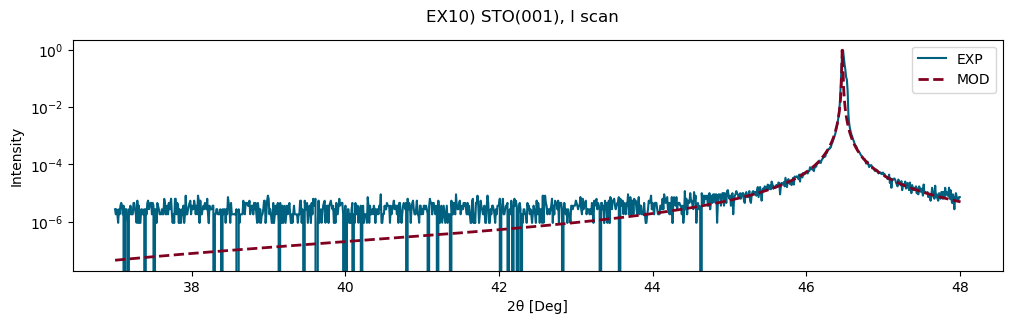

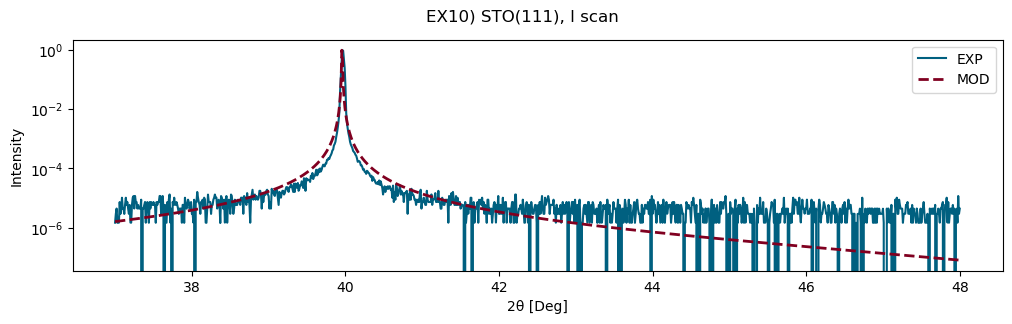

In [24]:
def EX10_EXP():
    plt.figure(figsize=(12,3))
    plt.suptitle("EX10) STO(001), l scan")
    # plt.subplot(1,2,1)
    expTT = np.arange(37, 48.01, 0.01)
    expII = list(map(float, RAWDATA001.split()))
    plt.semilogy(expTT, expII/np.max(expII), label='EXP', color='#006080')
    #
    # plt.subplot(1,2,2)
    XRD = Detector(CuKa1, film=Film(sto,(1,1,inf)))
    XRD.align(sto(0,0,1))
    XRD.degreeChange(37, 48.01, 1101)
    ER  = XRD.ER()
    plt.semilogy(XRD.DEGREE, np.abs(ER)**2/np.max(np.abs(ER)**2), linestyle='dashed', linewidth=2, color='#800020', label='MOD')
    plt.legend()
    plt.xlabel('2θ [Deg]')
    plt.ylabel('Intensity')
# EX10_EXP()
# def EX10_EXP():
    plt.figure(figsize=(12,3))
    plt.suptitle("EX10) STO(111), l scan")
    # plt.subplot(1,2,1)
    expTT = np.arange(37, 48.01, 0.01)
    expII = list(map(float, RAWDATA111.split()))
    plt.semilogy(expTT, expII/np.max(expII), label='EXP', color='#006080')
    #
    # plt.subplot(1,2,2)
    XRD = Detector(CuKa1, film=Film(sto,(1,1,inf)))
    XRD.align(sto(1,1,1))
    XRD.degreeChange(37, 48.01, 1101)
    ER  = XRD.ER()
    plt.semilogy(XRD.DEGREE, np.abs(ER)**2/np.max(np.abs(ER)**2), linestyle='dashed', linewidth=2, color='#800020', label='MOD')
    plt.legend()
    plt.xlabel('2θ [Deg]')
    plt.ylabel('Intensity')
EX10_EXP()

Imaginary Part : , norm(np.imag(nR_ref))


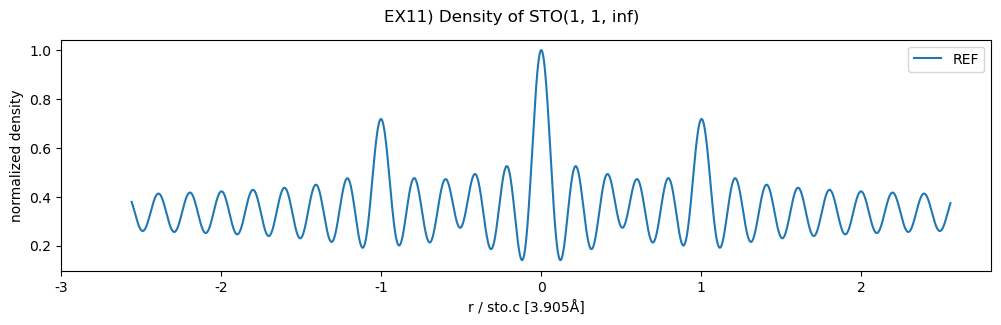

In [25]:
# AFF to n(r)
def EX11_Density():
    plt.figure(figsize = (12,3))
    # plt.subplot(1,2,1)
    R   = np.arange(-10, 10, 0.01) # Å unit
    XRD = Detector(CuKa1, film=Film(sto, (1,1,inf)))
    XRD.align(STO(0,0,1))
    ER  = XRD.ER()
    GG  = XRD.DK
    nR_ref = []
    for r in R:
        nR_ref.append( np.sum(ER) + np.sum(ER * exp(-1j * GG * r))+np.sum(ER * exp(1j * GG * r)) )
    print('Imaginary Part : , norm(np.imag(nR_ref))')
    nR_ref = np.real(nR_ref)
    plt.plot(R, nR_ref/np.max(nR_ref), label = 'REF')
    plt.legend()
    plt.xticks(np.arange(-3, 3, 1) * 3.905, np.arange(-3, 3, 1))
    plt.xlabel('r / sto.c [3.905Å]')
    plt.ylabel('normalized density')
    plt.suptitle('EX11) Density of STO(1, 1, inf)')
EX11_Density()